In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import functools
import itertools
from jax import numpy as jnp
import jax
import equinox as eqx
import distrax


@functools.partial(jax.jit, static_argnames=["num_bits"])
def num_to_binarray(num, num_bits):
    return jnp.array(jax.vmap(lambda i: num >> i & 1)(jnp.arange(num_bits)), dtype=jnp.int32)

class GridEnv(eqx.Module):
    state: jnp.ndarray
    r0: float = eqx.static_field()
    r1: float = eqx.static_field()
    r2: float = eqx.static_field()
    horizon: int = eqx.static_field()
    ndim: int = eqx.static_field()
    action_space: distrax.Categorical = eqx.static_field()

    def __init__(self, horizon, r0, r1, r2, ndim=2):
        self.state: jnp.ndarray = jnp.zeros(ndim, dtype=jnp.int32)
        self.ndim = ndim
        self.r0 = r0
        self.r1 = r1
        self.r2 = r2
        self.horizon = horizon
        self.action_space = distrax.Categorical(probs=jnp.ones(ndim + 1))

    @eqx.filter_jit
    def state_to_onehot(self, state):
        '''
        Converts a environment state to a one-hot encoded observation, for use with neural networks.
        '''
        observation = jnp.zeros((self.ndim*self.horizon,), dtype=jnp.float32)
        observation = observation.at[jnp.arange(self.ndim) * self.horizon + state].set(1)
        return observation

    @eqx.filter_jit
    def reward(self, state) -> jnp.ndarray:
        # normalize state
        tmp = jnp.abs(state/(self.horizon - 1) - 0.5) 
        indicator_r1 = jnp.prod(tmp > 0.25)
        indicator_r2 = jnp.prod((tmp > 0.3) *  (tmp < 0.4))
        r = self.r0 + self.r1 * indicator_r1 + self.r2 * indicator_r2
        return r

    @eqx.filter_jit
    def get_all_state_rewards(self):
        states = jnp.array(list(itertools.product(list(range(self.horizon)), repeat=self.ndim)))
        valids = jax.vmap(self.state_valid)(states)
        return {
            "states": states,
            "valids": valids,
            "rewards": jax.vmap(self.reward)(states) * valids
        }

    @eqx.filter_jit
    def state_valid(self, state):
        '''
        Checks if a state is in the observation space.
        '''
        return jnp.all(state >= 0) * jnp.all(state < self.horizon) *  (jnp.sum(state >= self.horizon - 1) <= 1)

    @eqx.filter_jit
    def step(grid, action):
        grid = jax.lax.cond(action < grid.state.shape[0], 
            lambda _: eqx.tree_at(
                lambda grid: grid.state, grid, grid.state.at[action].add(1)
            ), lambda _: grid, None)
        reward = grid.reward(grid.state)
        stop_step = action == grid.state.shape[0]
        horizon_finished = jnp.max(grid.state) >= grid.horizon - 1


        done = jax.lax.cond(horizon_finished, lambda _: True,  lambda _: stop_step, None)
        return (
            grid,
            reward,
            done 
        )

    @eqx.filter_jit
    def reset(self):
        grid = eqx.tree_at(
            lambda grid: grid.state, self, jnp.zeros_like(self.state)
        )
        return grid 

    @eqx.filter_jit
    def inverse_transitions(self, state):
        '''
        Returns a list of all possible state + actions that can transition to the given state. 
        Each element of the resulting PyTree also has a valid boolean, indicating if the state/action is valid.
        '''
        def get_index_parent(idx: int):
            tmp = state.at[idx].add(-1)
            pred = self.state_valid(tmp)
            return {"states":tmp, "valid":pred, "actions":idx}
        return jax.vmap(get_index_parent)(jnp.arange(state.shape[0])) 

    
    @eqx.filter_jit
    def transitions(self, state):
        def get_index_child(idx: int):
            tmp = state.at[idx].add(1)
            pred = self.state_valid(tmp)
            return {"states":tmp, "valid":pred, "actions":idx}
        return jax.vmap(get_index_child)(jnp.arange(state.shape[0])) 



env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
from src.gflownet import FlowNetwork

env = GridEnv(8, 0.1, 0.5, 2.0, 6)
all_state_rewards = env.get_all_state_rewards()
key = jax.random.PRNGKey(0)
agent = FlowNetwork(
    env.state_to_onehot(env.state).shape[0],
    [512, 512, 512],
    env.action_space.logits.shape[0],
    key,
)
agent_original = agent


2022-08-15 13:16:30.749024: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce.2 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2022-08-15 13:16:33.333002: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3.584084797s
Constant folding an instruction is taking > 1s:

  reduce.2 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't nec

[ 33147  33152  33187  33192  33462  33467  33502  33507  35597  35602
  35637  35642  35912  35917  35952  35957  52012  52017  52052  52057
  52327  52332  52367  52372  54462  54467  54502  54507  54777  54782
  54817  54822 177207 177212 177247 177252 177522 177527 177562 177567
 179657 179662 179697 179702 179972 179977 180012 180017 196072 196077
 196112 196117 196387 196392 196427 196432 198522 198527 198562 198567
 198837 198842 198877 198882]
Counter({0.10000000149011612: 216304, 0.6000000238418579: 2123, 2.5999999046325684: 64})
expected probs: {0.6000000238418579: 0.05533546109874851, 0.10000000149011612: 0.939651537152095, 2.5999999046325684: 0.00722862303595934}


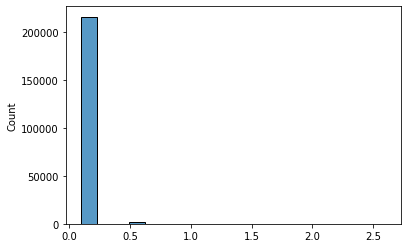

In [3]:
from collections import Counter


rewards = all_state_rewards["rewards"][all_state_rewards["valids"] == 1]
valid_states = all_state_rewards["states"][all_state_rewards["valids"] == 1]

best_reward = jnp.max(rewards)
reward_modes = jnp.argwhere(rewards == best_reward).flatten()
print(reward_modes)
# print(valid_states[reward_modes])

import seaborn as sns

# sns.histplot(rewards)

rc = (Counter([r.item() for r in rewards]))

rsum = sum(rewards).item()
rc_normalized = {k: v*k / rsum for k, v in rc.items()}

print(rc)
print("expected probs:", rc_normalized)

In [4]:
from typing import Dict


@eqx.filter_jit
def policy_trajectory(
    agent: FlowNetwork,
    env: GridEnv,
    steps_per_episode: int,
    key: jax.random.KeyArray,
) -> Dict[str, jnp.ndarray]:
    """
    Collects steps_per_episode steps from the environment using the agent's policy. Note that there may be multiple terminal states in the trajectory.
    """

    def loop(loopstate, _):
        key = jax.random.split(loopstate[0], 2)[1]
        env = loopstate[1]

        state = env.state
        encoded_state = env.state_to_onehot(state)
        transitions = env.transitions(env.state)
        flows = agent(encoded_state)
        flows = flows * jnp.concatenate([transitions["valid"], jnp.array([True])])
        action = distrax.Categorical(logits=flows).sample(seed=key)
        env, reward, done = env.step(action)
        env = jax.lax.cond(done, lambda _: env.reset(), lambda _: env, None)
        reward = jax.lax.cond(done, lambda _: reward, lambda _: 0.0, None)

        return (
            (key, env),
            {
                "states": state,
                "actions": action,
                "rewards": reward,
                "dones": done,
            },
        )

    (key, env), trajectory = jax.lax.scan(
        loop, (key, env), jnp.arange(steps_per_episode)
    )

    return trajectory


In [5]:
import optax

optimizer = optax.adam(1e-4)
optimizer_state = optimizer.init(eqx.filter(agent, eqx.filters.is_array))


In [6]:
from src.gflownet import flow_matching_loss
import tqdm

@eqx.filter_jit
def train_flownet(agent, key, env:GridEnv, optimizer_state):
    trajectories = jax.vmap(functools.partial(policy_trajectory, agent, env, env.ndim * env.horizon))(
        jax.random.split(key, 16)
    )

    def loss_grad(agent, trajectories):
        return jax.vmap(lambda t: flow_matching_loss(agent, t["states"],
            t["rewards"],
            t["dones"],
            t["actions"] == env.ndim,
            env.transitions,
            env.inverse_transitions,
            env.state_to_onehot))(trajectories).mean()

    loss, gradients = eqx.filter_value_and_grad(loss_grad)(agent, jax.lax.stop_gradient(trajectories))
    updates, optimizer_state = optimizer.update(gradients, optimizer_state, agent)
    agent = eqx.apply_updates(agent, updates)
    return loss, agent, env, optimizer_state


losses = []
for key in (t := tqdm.tqdm(jax.random.split(key, 10000))):
    loss, agent, env, optimizer_state = train_flownet(
        agent, key, env, optimizer_state
    )
    t.set_description(f"Loss: {loss}")
    losses.append(loss.item())


Loss: 0.056239545345306396: 100%|██████████| 10000/10000 [03:02<00:00, 54.72it/s]


<AxesSubplot:>

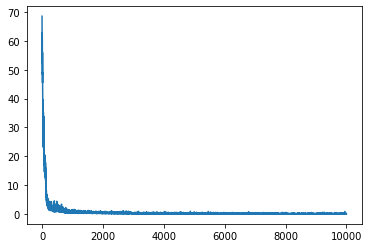

In [7]:
import seaborn as sns
sns.lineplot(x=range(len(losses)),y=losses)

(10000, 48, 6)
Counter({0.6000000238418579: 9345, 0.10000000149011612: 597, 2.5999999046325684: 58})


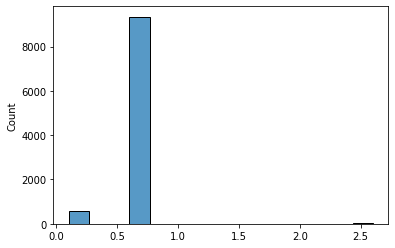

In [8]:
import numpy
key = jax.random.PRNGKey(10000000)
keys = jax.random.split(key, 10000)
rewards = []
trajectories = jax.vmap(functools.partial(policy_trajectory, agent_original, env, env.ndim*env.horizon))(keys)
rewards = jnp.max(trajectories["rewards"], axis=-1)
rewards_bestidx = jnp.argmax(trajectories["rewards"], axis=-1)
final_reward_action = jnp.take_along_axis(
    trajectories["actions"], rewards_bestidx[..., None], axis=-1
)

print(trajectories["states"].shape)
best_states = jax.vmap(lambda s, i: s[i])(trajectories["states"], rewards_bestidx)

import seaborn as sns

sns.histplot(rewards)
print(Counter([r.item() for r in rewards]))

# Counter([tuple(numpy.array(s).tolist()) for s in best_states])


(100000, 48, 6)
{0.10000000149011612: 0.95774, 0.6000000238418579: 0.04038, 2.5999999046325684: 0.00188} {0.6000000238418579: 0.05533546109874851, 0.10000000149011612: 0.939651537152095, 2.5999999046325684: 0.00722862303595934}


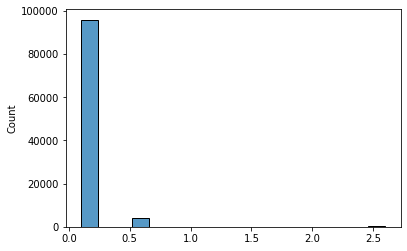

In [11]:

key = jax.random.PRNGKey(10000000)
keys = jax.random.split(key, 100000)
rewards = []
trajectories = jax.vmap(functools.partial(policy_trajectory, agent, env, env.ndim*env.horizon))(keys)
rewards = jnp.max(trajectories["rewards"], axis=-1)
rewards_bestidx = jnp.argmax(trajectories["rewards"], axis=-1)
final_reward_action = jnp.take_along_axis(
    trajectories["actions"], rewards_bestidx[..., None], axis=-1
)

print(trajectories["states"].shape)
best_states = jax.vmap(lambda s, i: s[i])(trajectories["states"], rewards_bestidx)

import seaborn as sns

sns.histplot(rewards)
rc = Counter([r.item() for r in rewards])
tc = sum(rc.values())
print({k: v/tc for k, v in rc.items()}, rc_normalized)

